In [33]:
import os
from py2neo import Graph, Node, Relationship
from itertools import permutations
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import uuid  
from typing import Dict, List, Optional, Union, Tuple
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time
import numpy as np
import random
import copy
import itertools
import numpy as np

In [34]:
from qiskit import transpile
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService,Sampler,Estimator
from scipy.optimize import minimize

In [35]:
user = os.getenv("DB_USER")
password = os.getenv("DB_PASS")
apiToken = os.getenv("QISKIT_APITOKEN")
graph_db: Graph = Graph("bolt://localhost:7687", auth=(user, password))

# Queries do banco de dados NEO4J

In [36]:
def shortPathByPOI(
    poiId1: str, 
    poiId2: str
) -> Optional[Dict[str, Union[float, List[str]]]]:

    if not poiId1 or not isinstance(poiId1, str):
        print(f"Invalid poiId1: {poiId1}")
        return None
    if not poiId2 or not isinstance(poiId2, str):
        print(f"Invalid poiId2: {poiId2}")
        return None
    
    query = '''
    MATCH (poi1:POI {osmid: $poiId1})-[:CONNECTED_TO]->(start:Node),
          (poi2:POI {osmid: $poiId2})-[:CONNECTED_TO]->(end:Node)
    CALL apoc.algo.dijkstra(start, end, 'ROAD_TO>', 'length') 
    YIELD path, weight
    RETURN 
        weight AS totalLength,
        [rel IN relationships(path) | id(rel)] AS streetsIds
    '''
    
    try:
        result = graph_db.run(query, poiId1=poiId1, poiId2=poiId2).data()
        
        if not result:
            print(f"No path found between POIs {poiId1} and {poiId2}")
            return None

        data = result[0]
        
        if 'totalLength' not in data or 'streetsIds' not in data:
            print(f"Unexpected result structure: {data}")
            return None
        
        return {
            "totalLength": round(data['totalLength'], 2),  
            "streetsIds": data['streetsIds'],
        }

    except Exception as e:
        print(f"An error occurred while querying the database: {str(e)}")
        return None


In [37]:

def getRoads() -> Optional[List[Dict[str, Union[int, float, str]]]]:
    query = '''
    MATCH (a)-[r:ROAD_TO]->(b)
    WHERE a.latitude IS NOT NULL AND a.longitude IS NOT NULL
      AND b.latitude IS NOT NULL AND b.longitude IS NOT NULL
    RETURN id(a) AS from_id, id(b) AS to_id,
           a.latitude AS from_lat, a.longitude AS from_lon,
           b.latitude AS to_lat, b.longitude AS to_lon,
           r.length AS length, id(r) AS rel_id,
           r.highway AS highway, r.name AS name, r.oneway AS oneway
    '''

    try:
        result = graph_db.run(query).data()

        if not result:
            print("No roads found. The query returned no data.")
            return []

        roads = []
        for record in result:
            road = {}

            if 'from_id' in record and 'to_id' in record:
                road['from_id'] = record['from_id']
                road['to_id'] = record['to_id']
            else:
                print(f"Missing ids for road: {record}")
                continue

            road['from_lat'] = record.get('from_lat', None)
            road['from_lon'] = record.get('from_lon', None)
            road['to_lat'] = record.get('to_lat', None)
            road['to_lon'] = record.get('to_lon', None)

            road['length'] = record.get('length', 0.0) 
            road['rel_id'] = record.get('rel_id', None)

            road['highway'] = record.get('highway', None)
            road['name'] = record.get('name', None)
            road['oneway'] = record.get('oneway', None)

            roads.append(road)

        return roads

    except Exception as e:
        print(f"An error occurred while fetching roads: {str(e)}")
        return []


In [38]:

def findPoiByLatAndLog(lat: float, lon: float) -> Optional[Dict[str, Union[str, float]]]:
    if not isinstance(lat, (float, int)) or not isinstance(lon, (float, int)):
        print(f"Erro: latitude ou longitude fornecida não são válidas. Latitude: {lat}, Longitude: {lon}")
        return None
    if not (-90 <= lat <= 90) or not (-180 <= lon <= 180):
        print(f"Erro: valores de latitude ou longitude fora do intervalo válido. Latitude: {lat}, Longitude: {lon}")
        return None
    query = '''
    MATCH (poi:POI)
    WHERE poi.latitude = $lat AND poi.longitude = $lon
    RETURN poi.osmid AS osmid, poi.name AS name, poi.latitude AS latitude, poi.longitude AS longitude
    '''
    try:
        result = graph_db.run(query, lat=lat, lon=lon).data()
        if not result:
            print(f"Aviso: Nenhum POI encontrado para Latitude: {lat}, Longitude: {lon}")
            return None
        data = result[0]
        if 'osmid' not in data or 'name' not in data or 'latitude' not in data or 'longitude' not in data:
            print(f"Erro: Estrutura de dados inesperada retornada. Dados: {data}")
            return None
        return {
            "osmid": data['osmid'],
            "name": data['name'],
            "latitude": data['latitude'],
            "longitude": data['longitude']
        }

    except Exception as e:
        print(f"Erro ao executar a consulta: {str(e)}")
        return None


In [39]:

def insert_poi(lat: float, lon: float, name:str,label='POI') -> Node:
    node = findPoiByLatAndLog(lat, lon)
    if(node):
        return node
    roads = getRoads()
    poi_point = Point(lon, lat)
    closest = None
    min_dist = float('inf')
    # Encontrar a aresta mais próxima ao ponto informado
    for road in roads:
        a = Point(road['from_lon'], road['from_lat'])
        b = Point(road['to_lon'], road['to_lat'])
        line = LineString([a, b])
        proj = line.interpolate(line.project(poi_point))
        dist = geodesic((lat, lon), (proj.y, proj.x)).meters

        if dist < min_dist:
            min_dist = dist
            closest = {**road, 'proj_point': proj}

    if not closest:
        print("Nenhuma aresta próxima encontrada.")
        return

    proj = closest['proj_point']

    mid_node = Node("Node",
                    latitude=proj.y,
                    longitude=proj.x,
                    osmid=str(uuid.uuid4()))
    
    graph_db.create(mid_node)
    
    poi_node = Node(label,
                    name=name,
                    latitude=lat,
                    longitude=lon,
                    osmid=str(uuid.uuid4())
                    )
    graph_db.create(poi_node)

    graph_db.create(Relationship(poi_node, "CONNECTED_TO", mid_node,
                                 distance=min_dist))

    # Remover aresta original
    graph_db.run("MATCH ()-[r]->() WHERE id(r) = $id DELETE r", id=closest['rel_id'])

    # Criar novas arestas dividindo a original
    from_id = closest['from_id']
    to_id = closest['to_id']
    mid_id = mid_node.identity

    len1 = geodesic((closest['from_lat'], closest['from_lon']), (proj.y, proj.x)).meters
    len2 = geodesic((closest['to_lat'], closest['to_lon']), (proj.y, proj.x)).meters

    graph_db.run('''
        MATCH (a), (b), (c)
        WHERE id(a) = $from_id AND id(b) = $to_id AND id(c) = $mid_id
        CREATE (a)-[:ROAD_TO {
            length: $len1,
            highway: $highway,
            name: $name,
            oneway: $oneway
        }]->(c),
        (c)-[:ROAD_TO {
            length: $len2,
            highway: $highway,
            name: $name,
            oneway: $oneway
        }]->(b)
    ''', parameters={
        "from_id": from_id,
        "to_id": to_id,
        "mid_id": mid_id,
        "len1": len1,
        "len2": len2,
        "highway": closest['highway'],
        "name": closest['name'],
        "oneway": closest['oneway'],
    })
    
    print(f"POI criado e conectado no ponto mais próximo da rua: {closest['name'] or 'desconhecida'}")
    return poi_node

# Função para gerar a matriz de distâncias

In [40]:

def build_distance_matrix(
    initial_point: Dict,
    target_points: List[Dict]
) -> Tuple[np.ndarray, List[List[List[str]]]]:
    
    all_points = [initial_point] + target_points
    n = len(all_points)

    dist_matrix = np.zeros((n, n))
    streets_matrix: List[List[List[str]]] = [[[] for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i == j:
                dist_matrix[i][j] = 0
                streets_matrix[i][j] = []
            else:
                p1 = all_points[i]['osmid']
                p2 = all_points[j]['osmid']
                segment = shortPathByPOI(p1, p2)
                dist_matrix[i][j] = segment.get('totalLength', 0)
                streets_matrix[i][j] = segment.get('streetsIds', [])

    return dist_matrix, streets_matrix

In [41]:
def extract_streets_from_path(path: List[Dict], initial_point: Dict, target_points: List[Dict], streets_matrix: List[List[List[str]]]) -> List[str]:
    from itertools import chain

    all_points = [initial_point] + target_points
    point_index = {p['osmid']: i for i, p in enumerate(all_points)}

    street_ids = []

    for i in range(len(path) - 1):
        idx1 = point_index[path[i]['osmid']]
        idx2 = point_index[path[i + 1]['osmid']]
        street_ids.append(streets_matrix[idx1][idx2])

    return list(chain.from_iterable(street_ids))


# Função de plot do mapa

In [42]:
def plotGrahp(points: List[Tuple[float, float, str]], coloredStreets: Optional[List[str]]= None, title: str = None) -> None:
    colors = itertools.cycle(plt.cm.tab10.colors)
    
    query_nodes = '''
    MATCH (n:Node)
    RETURN id(n) AS id, n.latitude AS lat, n.longitude AS lon
    '''

    query_edges = '''
    MATCH (a:Node)-[r:ROAD_TO]->(b:Node)
    RETURN id(r) AS id, 
           id(a) AS source,
           id(b) AS target,
           r.length AS length,
           r.name AS name,
           r.highway AS highway,
           r.oneway AS oneway
    '''

    nodes_df = pd.DataFrame(graph_db.run(query_nodes).data())
    edges_df = pd.DataFrame(graph_db.run(query_edges).data())

    G = nx.MultiDiGraph()
    G.graph['crs'] = 'epsg:4326'

    for _, row in nodes_df.iterrows():
        G.add_node(row['id'], x=row['lon'], y=row['lat'])

    for _, row in edges_df.iterrows():
        G.add_edge(
            row['source'],
            row['target'],
            key=row['id'],
            id=row['id'],
            length=row['length'],
            name=row['name'],
            highway=row['highway'],
            oneway=row['oneway'],
        )

    # Cores das ruas
    edge_colors = []
    for u, v, k, data in G.edges(keys=True, data=True):
        # display(data.get('id'), (data.get('id')) in coloredStreets)
        if(coloredStreets is None): edge_colors.append('lightgray')
        if coloredStreets and data.get('id') in coloredStreets:
            edge_colors.append('blue')
        else:
            edge_colors.append('lightgray')

    fig, ax = plt.subplots(figsize=(10, 10))

    ox.plot_graph(
        G,
        ax=ax,
        node_size=0.2,
        node_color="black",
        edge_color=edge_colors,
        edge_linewidth=0.7,
        bgcolor="white",
        show=False,
        close=False
    )

    plotLatAndLon = list(map(lambda poi: (poi['longitude'], poi['latitude'], poi['name']), points))
    for lon, lat, name in plotLatAndLon:
        color = next(colors)
        ax.scatter(lon, lat, c=[color], s=10, marker='o', zorder=10, label=name)
    plt.title(f'{title}')
    ax.legend(loc='upper right', fontsize=10)
    plt.show()


# definição dos pontos que vão ser usados

In [43]:

initialPoint = insert_poi(lat=-23.2848682, lon=-47.6720885, name='Ponto Inicial')

target_points = [
    insert_poi(lat=-23.2999866, lon=-47.6650897, name='Ponto 1'),
    insert_poi(lat=-23.2829741, lon=-47.6745936, name='Ponto 2'),
    insert_poi(lat=-23.276087796084404, lon=-47.67514362249426, name='Ponto 3'),
]

display(initialPoint, target_points)

{'osmid': '197aa31f-3c20-42b2-afdf-5e0b92a602a5',
 'name': 'Ponto Inicial',
 'latitude': -23.2848682,
 'longitude': -47.6720885}

[{'osmid': '9e573839-8b59-499f-80d9-1402d4a6680b',
  'name': 'Ponto 1',
  'latitude': -23.2999866,
  'longitude': -47.6650897},
 {'osmid': 'eba6e7a5-f155-4a7e-b141-cac6ab3fb2ca',
  'name': 'Ponto 2',
  'latitude': -23.2829741,
  'longitude': -47.6745936},
 {'osmid': '3d620160-bc2a-4c2e-991b-6467bea3cb7e',
  'name': 'Ponto 3',
  'latitude': -23.276087796084404,
  'longitude': -47.67514362249426}]

## mapa inicial com os pontos informados

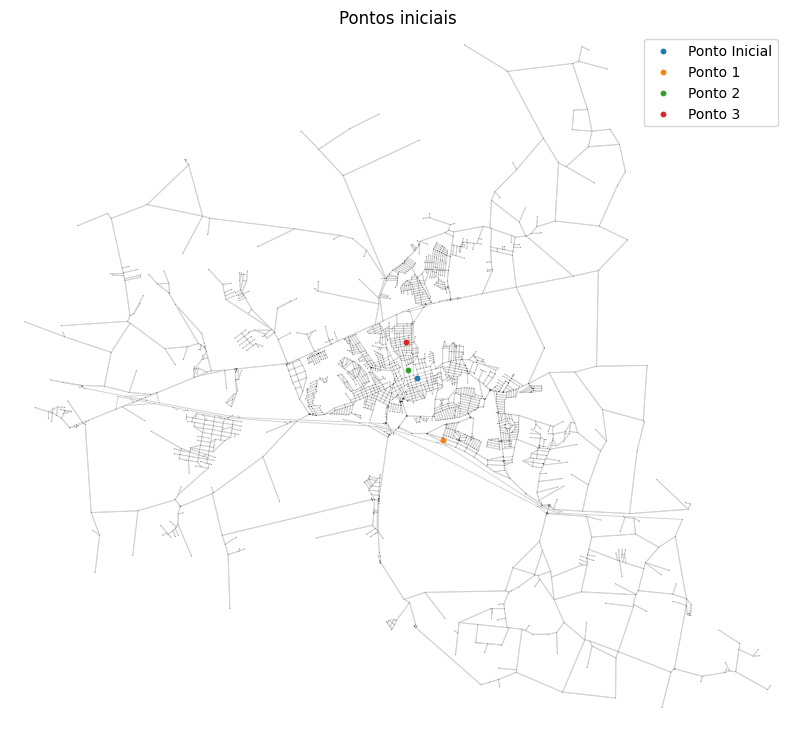

In [44]:
_points = list([initialPoint, *target_points])
plotGrahp(points=_points, title='Pontos iniciais')


# >> Força bruta
* O(n-1)!
* testa todas as possibilidades e retorna a melhor rota para nosso problema

In [45]:
def brute_force_shortest_path_with_matrix(
    initialpoint: Dict,
    points: List[Dict],
    dist_matrix: np.ndarray
) -> Tuple[List[Dict], float]:
    n = len(points) + 1 
    min_distance = float('inf')
    best_path = None
    pointer = 0
    point_indices = list(range(1, n)) 
    for perm in permutations(point_indices):
        path_indices = [0] + list(perm) + [0]
        total_distance = 0
        pointer += 1

        for i in range(len(path_indices) - 1):
            from_idx = path_indices[i]
            to_idx = path_indices[i+1]
            dist = dist_matrix[from_idx][to_idx]
            if dist == 0 and from_idx != to_idx:
                total_distance = float('inf')
                break
            total_distance += dist

        if total_distance < min_distance:
            min_distance = total_distance
            best_path = [initialpoint] + [points[i-1] for i in perm] + [initialpoint]

    print('Número de interações:', pointer)
    return best_path, min_distance

Número de interações: 6
Menor caminho:  ['Ponto Inicial', 'Ponto 1', 'Ponto 2', 'Ponto 3', 'Ponto Inicial']
Menor distância (m):  9197.890000000001
Tempo de execução: 0.0004 segundos


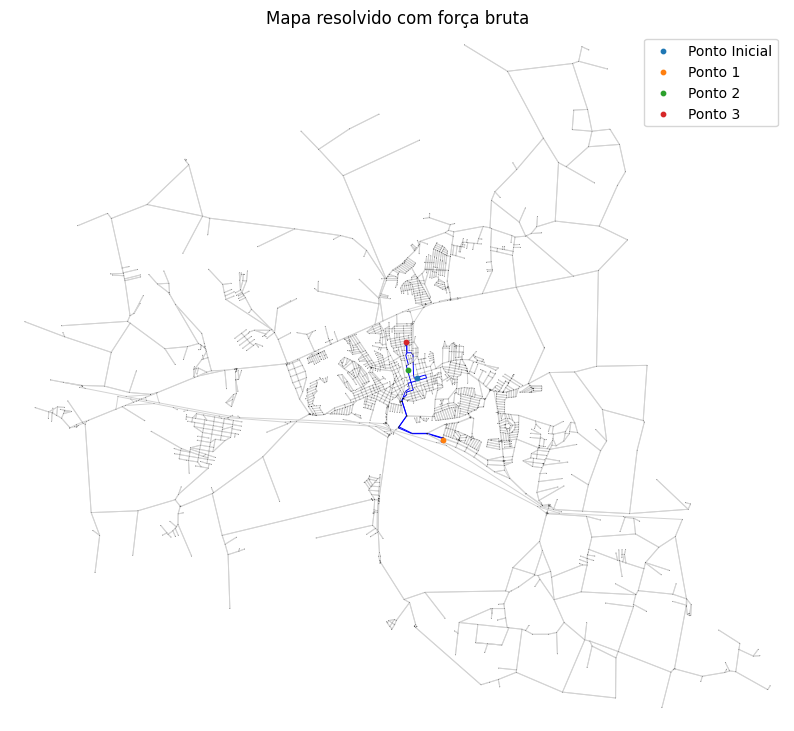

In [46]:
dist_matrix, streets_matrix = build_distance_matrix(initialPoint, target_points)

start_time = time.perf_counter()  
best_path, best_distance = brute_force_shortest_path_with_matrix(initialPoint, target_points, dist_matrix)
end_time = time.perf_counter() 

colored_streets = extract_streets_from_path(best_path, initialPoint, target_points, streets_matrix)

execution_time = end_time - start_time  
print("Menor caminho: ", list(map(lambda p: p['name'], best_path)))
print("Menor distância (m): ", best_distance)
print(f"Tempo de execução: {execution_time:.4f} segundos")

plotGrahp(points=_points, coloredStreets=colored_streets, title='Mapa resolvido com força bruta')

# >> Algoritmos Heurísticos (Genêtico)

In [47]:
dist_matrix_heuri, dist_street_heuri = build_distance_matrix(initialPoint, target_points)
display(dist_matrix_heuri)

array([[   0.  , 3781.95, 1106.94, 1331.58],
       [3168.62,    0.  , 3236.15, 4164.17],
       [ 850.9 , 3991.4 ,    0.  ,  928.02],
       [1251.77, 4286.63, 1455.76,    0.  ]])

In [48]:
#parametros
num_cities = len(dist_matrix_heuri) 

POPULATION_SIZE = 100
NUM_GENERATIONS = 500
MUTATION_RATE = 0.02
TOURNAMENT_SIZE = 5 
ELITISM_COUNT = 1 


In [49]:


def calculate_fitness(chromosome):
    total_distance = 0
    for i in range(len(chromosome) - 1):
        city_from = chromosome[i]
        city_to = chromosome[i+1]
        total_distance += dist_matrix_heuri[city_from][city_to]
    
    
    total_distance += dist_matrix_heuri[chromosome[-1]][chromosome[0]]
    
    return total_distance

def create_individual():
    cities = list(range(num_cities))
    random.shuffle(cities) 
    return cities

def initialize_population(size):
    population = []
    for _ in range(size):
        population.append(create_individual())
    return population

def tournament_selection(population, fitnesses, tournament_size):
    selected_individual = None
    best_fitness = float('inf') 
    
    for _ in range(tournament_size):
        candidate_index = random.randint(0, len(population) - 1)
        candidate = population[candidate_index]
        candidate_fitness = fitnesses[candidate_index]
        
        if candidate_fitness < best_fitness: 
            best_fitness = candidate_fitness
            selected_individual = candidate
            
    return selected_individual

def order_crossover(parent1, parent2):
    size = len(parent1)
    child1 = [-1] * size
    child2 = [-1] * size

    start_index = random.randint(0, size - 1)
    end_index = random.randint(start_index, size - 1)

    child1[start_index:end_index+1] = parent1[start_index:end_index+1]
    child2[start_index:end_index+1] = parent2[start_index:end_index+1]

    current_parent2_pos = (end_index + 1) % size
    current_child1_pos = (end_index + 1) % size
    while -1 in child1:
        if parent2[current_parent2_pos] not in child1:
            child1[current_child1_pos] = parent2[current_parent2_pos]
            current_child1_pos = (current_child1_pos + 1) % size
        current_parent2_pos = (current_parent2_pos + 1) % size
    
    current_parent1_pos = (end_index + 1) % size
    current_child2_pos = (end_index + 1) % size
    while -1 in child2:
        if parent1[current_parent1_pos] not in child2:
            child2[current_child2_pos] = parent1[current_parent1_pos]
            current_child2_pos = (current_child2_pos + 1) % size
        current_parent1_pos = (current_parent1_pos + 1) % size

    return child1, child2

def swap_mutation(chromosome, mutation_rate):
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(chromosome)), 2) 
        chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome


In [50]:

#algoritmo genetico implemtacao

def genetic_algorithm(distance_matrix, num_generations, population_size, mutation_rate, tournament_size, elitism_count):
    
    population = initialize_population(population_size)
    best_overall_route = None
    best_overall_distance = float('inf')

    for generation in range(num_generations):
        fitnesses = [calculate_fitness(individual) for individual in population]

        current_best_index = np.argmin(fitnesses)
        current_best_route = population[current_best_index]
        current_best_distance = fitnesses[current_best_index]

        if current_best_distance < best_overall_distance:
            best_overall_distance = current_best_distance
            best_overall_route = copy.deepcopy(current_best_route) # Garante que copiamos o objeto

        new_population = []

        sorted_population_with_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1])
        for i in range(elitism_count):
            new_population.append(copy.deepcopy(sorted_population_with_fitness[i][0]))

        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitnesses, tournament_size)
            parent2 = tournament_selection(population, fitnesses, tournament_size)
            
            child1, child2 = order_crossover(parent1, parent2)
            
            child1 = swap_mutation(child1, mutation_rate)
            child2 = swap_mutation(child2, mutation_rate)
            
            new_population.append(child1)
            if len(new_population) < population_size: 
                new_population.append(child2)
        
        population = new_population

        if generation % 50 == 0:
            print(f"Geração {generation}: Melhor distância = {best_overall_distance:.2f}, Rota = {best_overall_route}")

    print("\n--- Resultados Finais ---")
    print(f"Melhor rota encontrada: {best_overall_route}")
    print(f"Distância total da melhor rota: {best_overall_distance:.2f}")

    return best_overall_route, best_overall_distance



In [51]:
import time

start_time = time.perf_counter()
best_route, best_distance = genetic_algorithm(
    dist_matrix_heuri,
    NUM_GENERATIONS,
    POPULATION_SIZE,
    MUTATION_RATE,
    TOURNAMENT_SIZE,
    ELITISM_COUNT
)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f'Numero de interações: {NUM_GENERATIONS} x')
print(f"Tempo de execução: {execution_time:.4f} segundos")

Geração 0: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 50: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 100: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 150: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 200: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 250: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 300: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 350: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 400: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]
Geração 450: Melhor distância = 9197.89, Rota = [1, 2, 3, 0]

--- Resultados Finais ---
Melhor rota encontrada: [1, 2, 3, 0]
Distância total da melhor rota: 9197.89
Numero de interações: 500 x
Tempo de execução: 0.2516 segundos


# >> Algoritmo Quântico (QAOA)

In [52]:
QiskitRuntimeService.delete_account()


False

In [53]:
if apiToken:
    QiskitRuntimeService.save_account(channel="ibm_quantum", token=apiToken, overwrite=True, instance='ibm-q/open/main')
    runTimeService = QiskitRuntimeService()    

else:
    print('Informe o token para conectar a ibm')


## listagem de servidores/simuladores disponíveis e escolha

In [54]:
from qiskit_aer import AerSimulator

for backend in runTimeService.backends():
    print(backend.name, backend.status())


# backend = runTimeService.backend(name='ibm_brisbane')
backend = AerSimulator()

ibm_sherbrooke <qiskit_ibm_runtime.models.backend_status.BackendStatus object at 0x0000017D4DFE1790>
ibm_brisbane <qiskit_ibm_runtime.models.backend_status.BackendStatus object at 0x0000017D4E29AEA0>


## tratando o input do algoritmo quântico

In [55]:
all_points = [initialPoint, *target_points, initialPoint] 
dist_matrix, streets_matrix = build_distance_matrix(initialPoint, target_points)
display(dist_matrix)

array([[   0.  , 3781.95, 1106.94, 1331.58],
       [3168.62,    0.  , 3236.15, 4164.17],
       [ 850.9 , 3991.4 ,    0.  ,  928.02],
       [1251.77, 4286.63, 1455.76,    0.  ]])

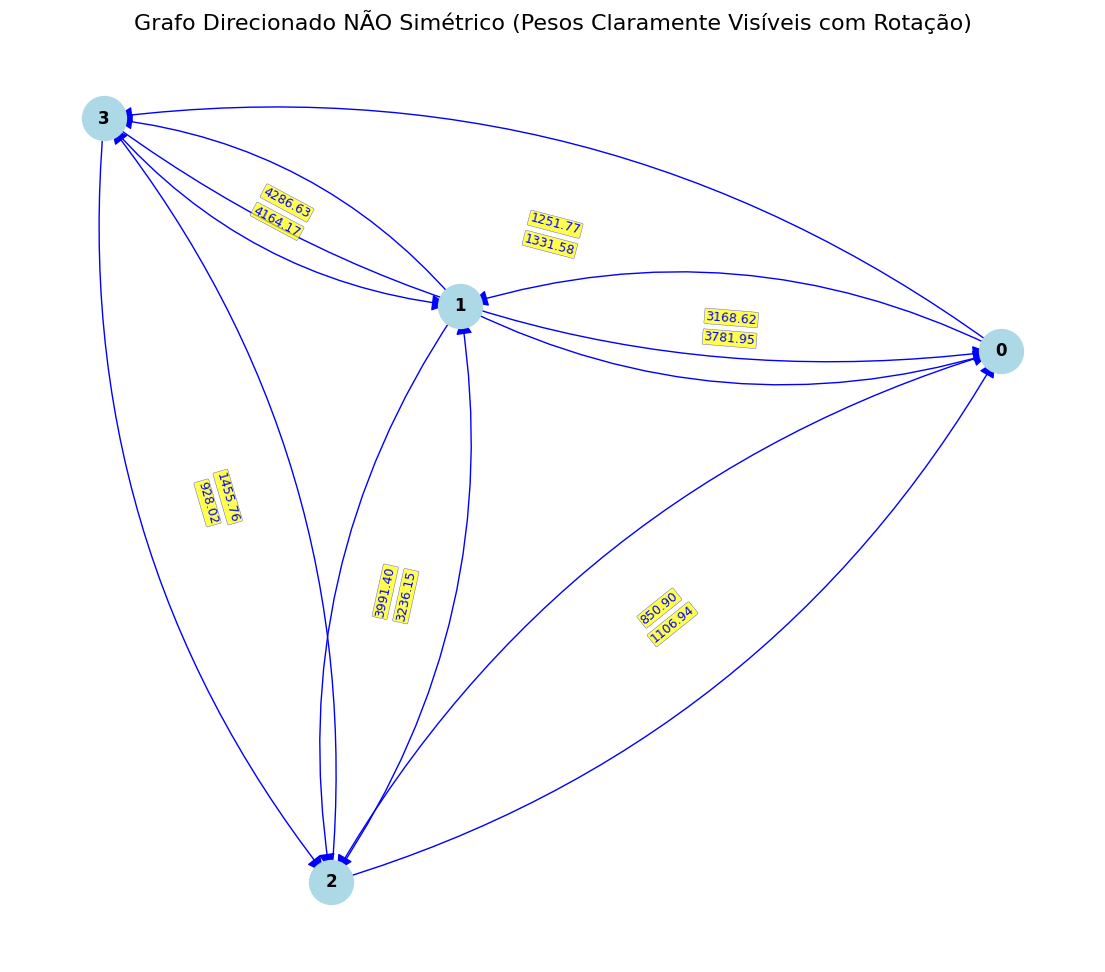

In [56]:
np.random.seed(13)
G = nx.DiGraph()
n = dist_matrix.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            G.add_edge(i, j, weight=dist_matrix[i][j])
            
pos = nx.spring_layout(G, seed=13)
plt.figure(figsize=(14, 12)) 
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold') 

edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {edge: f"{weight:.2f}" for edge, weight in edge_labels.items()}
rad = 0.2
label_offset_distance = 0.02
drawn_reciprocal_pairs = set()
for u, v in G.edges():
    
    has_reciprocal = G.has_edge(v, u)

    x1, y1 = pos[u]
    x2, y2 = pos[v]

    if has_reciprocal and (u, v) not in drawn_reciprocal_pairs: 
        
        drawn_reciprocal_pairs.add((u, v))
        drawn_reciprocal_pairs.add((v, u))

        
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2

        
        vec_x, vec_y = x2 - x1, y2 - y1
        dist_uv = np.sqrt(vec_x**2 + vec_y**2)
        if dist_uv == 0: continue 

        
        norm_vec_x, norm_vec_y = vec_x / dist_uv, vec_y / dist_uv

        
        perp_x, perp_y = -norm_vec_y, norm_vec_x

        
        angle_deg = np.degrees(np.arctan2(vec_y, vec_x))
        
        if angle_deg > 90 or angle_deg < -90:
            angle_deg += 180

        
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], arrowsize=25,
                               connectionstyle=f'arc3,rad={rad}', edge_color='blue', arrows=True)
        
        
        label_pos_u_v_x = mid_x + perp_x * label_offset_distance
        label_pos_u_v_y = mid_y + perp_y * label_offset_distance
        plt.text(label_pos_u_v_x, label_pos_u_v_y, edge_labels[(u, v)], 
                 color='blue', fontsize=9, ha='center', va='center', rotation=angle_deg,
                 bbox=dict(boxstyle="round,pad=0.1", fc="yellow", ec="blue", lw=0.3, alpha=0.7)) 

        
        nx.draw_networkx_edges(G, pos, edgelist=[(v, u)], arrowsize=25,
                               connectionstyle=f'arc3,rad={rad}', edge_color='blue', arrows=True)
        
        label_pos_v_u_x = mid_x - perp_x * label_offset_distance
        label_pos_v_u_y = mid_y - perp_y * label_offset_distance
        plt.text(label_pos_v_u_x, label_pos_v_u_y, edge_labels[(v, u)], 
                 color='blue', fontsize=9, ha='center', va='center', rotation=angle_deg,
                 bbox=dict(boxstyle="round,pad=0.1", fc="yellow", ec="blue", lw=0.3, alpha=0.7)) 

    elif not has_reciprocal: 
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], arrowsize=25,
                               edge_color='gray', arrows=True)
        
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        
        vec_x, vec_y = x2 - x1, y2 - y1
        angle_deg = np.degrees(np.arctan2(vec_y, vec_x))
        if angle_deg > 90 or angle_deg < -90:
            angle_deg += 180

        plt.text(mid_x, mid_y, edge_labels[(u, v)],
                 color='gray', fontsize=9, ha='center', va='center', rotation=angle_deg,
                 bbox=dict(boxstyle="round,pad=0.1", fc="lightgray", ec="gray", lw=0.3, alpha=0.7))

plt.title("Grafo Direcionado NÃO Simétrico (Pesos Claramente Visíveis com Rotação)", fontsize=16)
plt.axis('off') 
plt.show()


## como nosso problema é uma matriz assimetrica precisamos tomar mais cuidado com as particularidades

* matriz assimetrica = a matriz de distancia de um ponto para outro pode variar. Ex A->B=200m B->A=100m. Isso acontece pois estamos trabalhando com ruas de uma cidade

In [57]:
def adjacency_matrix_to_qubo(adj_matrix):
    """
    Converte matriz de adjacência para formulação QUBO do TSP
    Para 4 cidades, usamos 16 qubits (4x4 matriz binária)
    x_ij = 1 se visitamos cidade i na posição j do tour
    """
    n = len(adj_matrix)
    
    pauli_list = []
    
    # Função objetivo minimizar distâncias entre cidades consecutivas
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i != j:
                    # Cidade i na posição k e cidade j na posição seguinte (k+1)%n
                    qubit1 = i * n + k
                    qubit2 = j * n + ((k + 1) % n)
                    
                    # Adicionar termo de distância (queremos minimizar, então coeficiente positivo)
                    pauli_str = ['I'] * (n * n)
                    pauli_str[qubit1] = 'Z'
                    pauli_str[qubit2] = 'Z'
                    # Usar (1-Z)/2 para converter de {-1,1} para {0,1}
                    # Mas aqui já trabalhamos com ZZ que dá +1 quando ambos são |1⟩
                    pauli_list.append((''.join(reversed(pauli_str)), adj_matrix[i][j] / 4))
                    
                    # Termos lineares para implementar (1-Z_i)/2 * (1-Z_j)/2
                    pauli_str1 = ['I'] * (n * n)
                    pauli_str1[qubit1] = 'Z'
                    pauli_list.append((''.join(reversed(pauli_str1)), -adj_matrix[i][j] / 4))
                    
                    pauli_str2 = ['I'] * (n * n)
                    pauli_str2[qubit2] = 'Z'
                    pauli_list.append((''.join(reversed(pauli_str2)), -adj_matrix[i][j] / 4))
                    
                    # Termo constante
                    pauli_str_const = ['I'] * (n * n)
                    pauli_list.append((''.join(pauli_str_const), adj_matrix[i][j] / 4))
    
    # RESTRIÇÕES com penalidades altas
    penalty = 100000  # Penalidade muito alta para violações
    
    # Restrição 1: Exatamente uma cidade por posição no tour
    for k in range(n):
        # Penalizar se mais de uma cidade na posição k
        for i in range(n):
            for j in range(i+1, n):
                qubit1 = i * n + k
                qubit2 = j * n + k
                pauli_str = ['I'] * (n * n)
                pauli_str[qubit1] = 'Z'
                pauli_str[qubit2] = 'Z'
                pauli_list.append((''.join(reversed(pauli_str)), penalty))
        
        # Penalizar se nenhuma cidade na posição k
        for i in range(n):
            qubit = i * n + k
            pauli_str = ['I'] * (n * n)
            pauli_str[qubit] = 'Z'
            pauli_list.append((''.join(reversed(pauli_str)), -penalty))
        
        # Termo constante para garantir exatamente 1
        pauli_str_const = ['I'] * (n * n)
        pauli_list.append((''.join(pauli_str_const), penalty))
    
    # Restrição 2: Cada cidade aparece exatamente uma vez no tour
    for i in range(n):
        # Penalizar se cidade i aparece em mais de uma posição
        for k in range(n):
            for l in range(k+1, n):
                qubit1 = i * n + k
                qubit2 = i * n + l
                pauli_str = ['I'] * (n * n)
                pauli_str[qubit1] = 'Z'
                pauli_str[qubit2] = 'Z'
                pauli_list.append((''.join(reversed(pauli_str)), penalty))
        
        # Penalizar se cidade i não aparece em nenhuma posição
        for k in range(n):
            qubit = i * n + k
            pauli_str = ['I'] * (n * n)
            pauli_str[qubit] = 'Z'
            pauli_list.append((''.join(reversed(pauli_str)), -penalty))
        
        # Termo constante para garantir exatamente 1
        pauli_str_const = ['I'] * (n * n)
        pauli_list.append((''.join(pauli_str_const), penalty))
    hamiltonian = SparsePauliOp.from_list(pauli_list, num_qubits=n*n)
    return hamiltonian

In [58]:
def cost_function(params, ansatz, hamiltonian, estimator):
    bound_circuit = ansatz.assign_parameters(params)
    job = estimator.run([(bound_circuit, hamiltonian)])
    result = job.result()
    return result[0].data.evs

In [59]:
def fix_invalid_solution(solution_matrix, n):
    """Corrige uma solução inválida para criar um ciclo hamiltoniano válido"""
    print("Aplicando heurística de correção...")
    order = []
    used_cities = set()
    for pos in range(n):
        best_city = None
        for city in range(n):
            if city not in used_cities:
                if best_city is None:
                    best_city = city
                elif solution_matrix[city][pos] > solution_matrix[best_city][pos]:
                    best_city = city
        if best_city is not None:
            order.append(best_city)
            used_cities.add(best_city)
    for city in range(n):
        if city not in used_cities:
            order.append(city)
    order = order[:n]
    print(f"Ordem corrigida: {order}")
    return order

In [60]:
def decode_solution(counts, n=4):
    """Decodifica a solução quântica para ordem das cidades garantindo ciclo hamiltoniano"""
    # Pega as 5 soluções com maior probabilidade para tentar encontrar uma válida
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    for bitstring, count in sorted_counts[:10]:  # Tenta as 10 melhores
        print(f"Tentando bitstring: {bitstring} (probabilidade: {count/1024*100:.1f}%)")
        
        # Converte string binária para matriz
        solution_matrix = np.zeros((n, n), dtype=int)
        for i, bit in enumerate(bitstring):
            if bit == '1':
                row = i // n
                col = i % n
                solution_matrix[row][col] = 1
        
        print("Matriz de solução:")
        for i, row in enumerate(solution_matrix):
            print(f"Cidade {i}: {row}")
        
        # Verifica se é uma solução válida (cada linha e coluna soma 1)
        row_sums = np.sum(solution_matrix, axis=1)
        col_sums = np.sum(solution_matrix, axis=0)
        
        print(f"Somas das linhas (cada cidade): {row_sums}")
        print(f"Somas das colunas (cada posição): {col_sums}")
        
        # Solução válida: cada cidade aparece exatamente uma vez, cada posição tem exatamente uma cidade
        if np.all(row_sums == 1) and np.all(col_sums == 1):
            # Extrai a ordem das cidades
            order = []
            for time_step in range(n):
                for city in range(n):
                    if solution_matrix[city][time_step] == 1:
                        order.append(city)
                        break
            return order, solution_matrix
        else:
            print("Solução inválida, tentando próxima...")
            print()
    
    print("Nenhuma solução válida encontrada, usando heurística para corrigir a melhor...")
    # Se não encontrou solução válida, usa a melhor e corrige
    best_bitstring = sorted_counts[0][0]
    solution_matrix = np.zeros((n, n), dtype=int)
    for i, bit in enumerate(best_bitstring):
        if bit == '1':
            row = i // n
            col = i % n
            solution_matrix[row][col] = 1
    
    # Heurística de correção: criar um tour válido
    order = fix_invalid_solution(solution_matrix, n)
    
    # Criar nova matriz válida
    fixed_matrix = np.zeros((n, n), dtype=int)
    for pos, city in enumerate(order):
        fixed_matrix[city][pos] = 1
    
    return order, fixed_matrix

In [61]:
def calculate_path_distance(order, adj_matrix):
    """Calcula a distância total do caminho"""
    distance = 0
    n = len(order)
    for i in range(n):
        distance += adj_matrix[order[i]][order[(i+1) % n]]
    return distance

In [62]:
def extract_relevant_qubits(counts, qubit_indices):
    """
    Extrai apenas os bits dos qubits relevantes
    qubit_indices: lista dos índices dos qubits que você está usando
    """
    filtered_counts = {}
    for bitstring, count in counts.items():
        # Extrai apenas os bits nas posições dos qubits relevantes
        relevant_bits = ''.join([bitstring[-(i+1)] for i in qubit_indices])
        if relevant_bits in filtered_counts:
            filtered_counts[relevant_bits] += count
        else:
            filtered_counts[relevant_bits] = count
    return filtered_counts

In [63]:
def solve_tsp_qaoa(adj_matrix, p=1):
    """
    Resolve TSP usando QAOAAnsatz diretamente
    """
    print("Matriz de Adjacência:")
    for i, row in enumerate(adj_matrix):
        print(f"Cidade {i}: {row}")
    print()
    
    # Converter para QUBO
    hamiltonian = adjacency_matrix_to_qubo(adj_matrix)
    print(f"Hamiltoniano criado com {len(hamiltonian)} termos")

    simulator = backend
    
    # Criar ansatz QAOA
    qaoa_ansatz = QAOAAnsatz(hamiltonian, reps=p)
    qaoa_ansatz = transpile(qaoa_ansatz,backend=simulator,optimization_level=1)
    hamiltonian = hamiltonian.apply_layout(qaoa_ansatz.layout) 
    print(f"Circuito QAOA criado com {qaoa_ansatz.num_qubits} qubits e {qaoa_ansatz.num_parameters} parâmetros")
   
    estimator = EstimatorV2(mode=simulator)
    sampler = SamplerV2(mode=simulator)
    
    # Parâmetros iniciais aleatórios
    initial_params = np.random.uniform(0, 2*np.pi, qaoa_ansatz.num_parameters)
    
    print("Iniciando otimização clássica...")
    
    # Otimização clássica
    result = minimize(
        cost_function,
        initial_params,
        args=(qaoa_ansatz, hamiltonian, estimator),
        method='COBYLA',
        options={'maxiter': 2,}
    )
    
    optimal_params = result.x
    optimal_value = result.fun
    
    print(f"\nOtimização concluída!")
    print(f"Valor ótimo encontrado: {optimal_value:.4f}")
    print(f"Sucesso: {result.success}")
    
    # Criar circuito com parâmetros ótimos e medições
    optimal_circuit = qaoa_ansatz.assign_parameters(optimal_params)

    optimal_circuit.measure_all()
       
    print(f"Executando circuito no simulador...")
    
    job = sampler.run([optimal_circuit], shots=4)
    result = job.result()#.get_counts()
    counts = result[0].data.meas.get_counts()
    
    print(f"Top 5 resultados mais prováveis:")
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    for i, (bitstring, count) in enumerate(sorted_counts[:5]):
        print(f"{i+1}. {bitstring}: {count} vezes ({count/1024*100:.1f}%)")
    
    # Decodificar solução
    counts_filtred = extract_relevant_qubits(counts, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    order, solution_matrix = decode_solution(counts_filtred,len(adj_matrix))
    
    print("\nMatriz de Solução (cidade x tempo):")
    print("Linhas = Cidades, Colunas = Ordem de Visita")
    for i, row in enumerate(solution_matrix):
        print(f"Cidade {i}: {row}")
    print()
    
    # Calcular distância da solução QAOA
    qaoa_distance = calculate_path_distance(order, adj_matrix)
    
    print(f"Ordem encontrada pelo QAOA: {order}")
    print(f"Distância do caminho QAOA: {qaoa_distance}")
    
    return order, qaoa_distance

In [64]:
print("=== RESOLVENDO TSP COM QAOA ===\n")

optimal_order, optimal_distance = solve_tsp_qaoa(dist_matrix, p=4)

n = len(dist_matrix)
cities = list(range(n))
best_classical_distance = float('inf')
best_classical_order = None
    
print("\nComparação com todas as permutações possíveis:")
for perm in itertools.permutations(cities):
    distance = calculate_path_distance(list(perm), dist_matrix)
    print(f"Ordem {list(perm)}: distância = {distance}")
    if distance < best_classical_distance:
        best_classical_distance = distance
        best_classical_order = list(perm)

print(f"\nMelhor solução clássica: {best_classical_order}")
print(f"Distância ótima: {best_classical_distance}")

# Verificar se QAOA encontrou o ótimo
if optimal_distance == best_classical_distance:
    print("QAOA encontrou a solução ótima!")
else:
    print(f"QAOA não encontrou o ótimo (diferença: {optimal_distance - best_classical_distance})")
    

print(f"\n=== RESULTADO FINAL ===")
print(f"Ordem dos pontos para menor caminho: {optimal_order}")
print(f"Distância total: {optimal_distance}")

=== RESOLVENDO TSP COM QAOA ===

Matriz de Adjacência:
Cidade 0: [   0.   3781.95 1106.94 1331.58]
Cidade 1: [3168.62    0.   3236.15 4164.17]
Cidade 2: [ 850.9  3991.4     0.    928.02]
Cidade 3: [1251.77 4286.63 1455.76    0.  ]

Hamiltoniano criado com 280 termos
Circuito QAOA criado com 16 qubits e 8 parâmetros
Iniciando otimização clássica...

Otimização concluída!
Valor ótimo encontrado: 856718.8648
Sucesso: False
Executando circuito no simulador...
Top 5 resultados mais prováveis:
1. 0101010110100000: 1 vezes (0.1%)
2. 0011101110011000: 1 vezes (0.1%)
3. 0110000100110000: 1 vezes (0.1%)
4. 1001011011111110: 1 vezes (0.1%)
Tentando bitstring: 0000010110101010 (probabilidade: 0.1%)
Matriz de solução:
Cidade 0: [0 0 0 0]
Cidade 1: [0 1 0 1]
Cidade 2: [1 0 1 0]
Cidade 3: [1 0 1 0]
Somas das linhas (cada cidade): [0 2 2 2]
Somas das colunas (cada posição): [2 1 2 1]
Solução inválida, tentando próxima...

Tentando bitstring: 0001100111011100 (probabilidade: 0.1%)
Matriz de solução:
Ci